***
# <font color=green size=10>Lista 2: Inferência estatística via simulação</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

Aluno: Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

**Definindo constantes globais.**

In [2]:
# valor da semente padrão
SEED = 42

**Montando o dataset da lista.**

In [29]:
# carrega os arquivos csv originais
climbing_statistics = pd.read_csv("climbing_statistics.csv")
rainier_weather = pd.read_csv("Rainier_Weather.csv")

# junta os arquivos, elimina linhas e colunas desnecessárias e renomeia colunas
dados_completos = climbing_statistics.merge(rainier_weather, left_on="Date", right_on="Date", how="left")
dados_completos = dados_completos.drop(["Success Percentage", "Battery Voltage AVG"], axis=1)
dados_completos = dados_completos.query("Attempted >= Succeeded")
dados_completos = dados_completos.rename(columns={"Date": "Data", "Succeeded": "Sucessos", "Attempted": "Tentativas",
                              "Temperature AVG": "Temperatura", "Relative Humidity AVG": "Umidade_relativa",
                              "Wind Speed Daily AVG": "Velocidade_vento", "Wind Direction AVG": "Direc_vento",
                              "Solare Radiation AVG": "Radiacao_solar"})

# aplica as transformações nos dados
dados_completos.Temperatura = (dados_completos.Temperatura - 32) * 5 / 9
dados_completos["Cleaver"] = dados_completos.Route == "Disappointment Cleaver"
dados_completos.Data = pd.to_datetime(dados_completos.Data)

# reordena as colunas de acordo com o layout definido para a lista
dados_completos = dados_completos.reindex(columns=["Data", "Sucessos", "Route", "Tentativas", "Temperatura", "Umidade_relativa",
                               "Velocidade_vento", "Direc_vento", "Radiacao_solar", "Cleaver"])

___

"O Monte Rainier é um estratovulcão, e a montanha mais alta do estado norte-americano de Washington.(. . . ) Sua altitude é de 4392m e, em dias de tempo claro, seu pico permanentemente nevado pode ser facilmente avistado de Seattle e outras cidades da região." (*wikipédia*)

Um conjunto de dados sobre tentativas de se escalar o Monte Rainier está disponível no site *Kaggle*, e pode ser obtido pelo link [https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3](https://www.kaggle.com/codersree/mount-rainier-weather-and-climbing-data/version/3).

Usaremos Modelos Lineares Generalizados para descrever como o número de montanhistas que alcançam o cume do monte em um dado dia (sucessos) varia em função da temperatura média do ar (em graus Celsius).

A seguir apresentamos a estrutura do banco de dados.

In [31]:
dados_completos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4067 entries, 0 to 4076
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              4067 non-null   datetime64[ns]
 1   Sucessos          4067 non-null   int64         
 2   Route             4067 non-null   object        
 3   Tentativas        4067 non-null   int64         
 4   Temperatura       1889 non-null   float64       
 5   Umidade_relativa  1889 non-null   float64       
 6   Velocidade_vento  1889 non-null   float64       
 7   Direc_vento       1889 non-null   float64       
 8   Radiacao_solar    1889 non-null   float64       
 9   Cleaver           4067 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 321.7+ KB


Considere o modelo $$Y_{ij} \sim Poisson(\lambda_{ij})\\ \lambda_{ij} = exp(\alpha + \beta t_{i}),$$

onde $Y_{ij}$ representa o número de montanhistas que atingiram o cume pela rota $j$ no dia $i$, $\alpha$ e $\beta$ são parâmetros desconhecidos do modelo e $t_{i}$ indica a temperatura média no dia $i$. Para uma determinada temperatura, o modelo prevê o mesmo valor para todas as rotas. Desconsidere os dados da rota *glacier only - no summit attempt*. Por fim, note que para obter o valor de $y_{ij}$ é preciso somar todos os sucessos registrados no dia $i$ para a rota $j$.

In [32]:
dados = dados_completos.query("Route != 'glacier only - no summit attempt'")

## Questão 1)

### a)

___

Conduza um teste de hipóteses por simulação para avaliar a hipótese nula de que a média do número de sucessos obtidos pela rota "Disappointment Cleaver" é igual a média das demais rotas (conjuntamente).


In [37]:
dados.groupby(["Cleaver"]).agg({"Sucessos": ["sum", "mean", "count"]})

Sucessos                
             sum      mean count
Cleaver                         
False       2668  2.082748  1281
True        8246  3.031618  2720

In [36]:
dados.query("Sucessos > 0").groupby(["Cleaver"]).agg({"Sucessos": ["sum", "mean", "count"]})

Sucessos                
             sum      mean count
Cleaver                         
False       2668  4.214850   633
True        8246  5.093267  1619

In [62]:
diferenca_real = abs(4.214850 - 5.093267)
diferenca_real

0.8784169999999998

In [63]:
lista = dados.query("Sucessos > 0").Sucessos.tolist()
diferencas = []

for i in range(1001):
    lista_sorteada = np.random.choice(lista, size=1619 + 633, replace=False)
    media_true = np.mean(lista_sorteada[:1619])
    media_false = np.mean(lista_sorteada[1620:])
    diferencas.append(abs(media_true - media_false))

<AxesSubplot:ylabel='Density'>

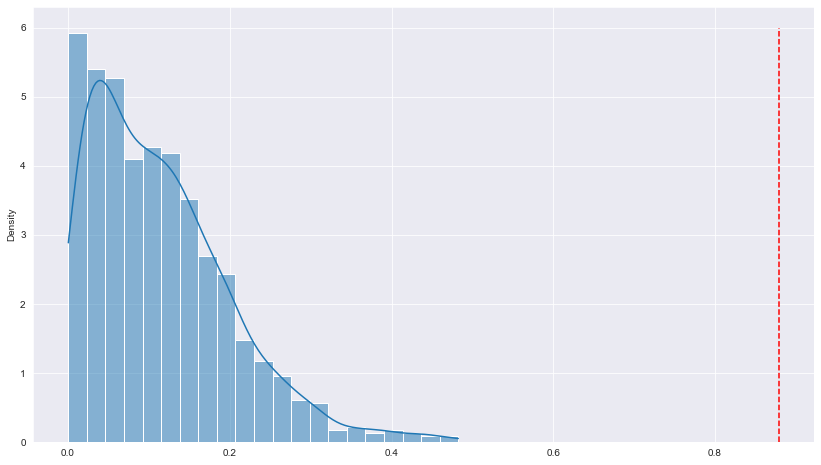

In [72]:
ax = sns.histplot(diferencas, kde=True, stat="density")
ax.figure.set_size_inches(14, 8)
ax.vlines(x=diferenca_real, ymin=0, ymax=6, colors='red', linestyles='dashed')
ax

In [112]:
lista_cleaver_true = np.random.choice(dados.query("Sucessos > 0 and Cleaver == True").Sucessos.tolist(), size=50)
print(len(lista_cleaver_true))
medias_cleaver_true = np.mean(lista_cleaver_true)
medias_cleaver_true

50


5.36

In [113]:
lista_cleaver_false = np.random.choice(dados.query("Sucessos > 0 and Cleaver == False").Sucessos.tolist(), size=50)
print(len(lista_cleaver_false))

medias_cleaver_false = np.mean(lista_cleaver_false)
medias_cleaver_false

50


4.74

In [114]:
diferencas_medias_cleaver = abs(medias_cleaver_true - medias_cleaver_false)
diferencas_medias_cleaver

0.6200000000000001

In [115]:
lista = list(lista_cleaver_false) + list(lista_cleaver_true)
len(lista)

100

In [116]:
diferencas = []

for i in range(1001):
    lista_sorteada = np.random.choice(lista, size=100, replace=False)
    media_true = np.mean(lista_sorteada[:50])
    media_false = np.mean(lista_sorteada[50:])
    diferencas.append(abs(media_true - media_false))

<AxesSubplot:ylabel='Density'>

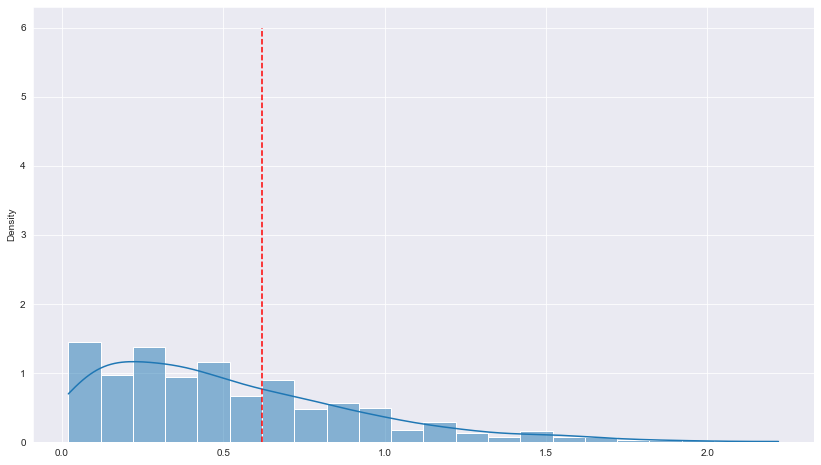

In [117]:
ax = sns.histplot(diferencas, kde=True, stat="density")
ax.figure.set_size_inches(14, 8)
ax.vlines(x=diferencas_medias_cleaver, ymin=0, ymax=6, colors='red', linestyles='dashed')
ax

<font color='red'>**Resposta:**</font>

### b)

___

Obtenha o estimador de máxima verossimilhança de $\alpha$ e $\beta$ considerando o modelo proposto. Dica: Use a função $\textsf{optim}$ do $\textbf{\textsf{R}}$ para achar o ponto que maximiza a log-verossimilhança.

### c)

___

Estime a distribuição de probabilidade do número de sucessos previstos para um dia em que atemperatura seja de 15 graus.

### d)

___

Construa um intervalo de confiança de 95% para $exp(\beta)$ a partir do método de bootstrap paramétrico. Interprete o resultado considerando o contexto dos dados. Dica: calcule o aumento percentual da média esperada quando a temperatura aumenta em 1 grau Celsius.

### e)

___

Faça um diagnóstico do modelo via simulação. Para tanto, gere dados sintéticos usando o modelo obtido no item $\textsf{b)}$, ajuste um novo modelo sobre os dados sintéticos e calcule o Erro quadrático médio(MSE). Repita esse procedimento 10000 vezes e compare os MSEs gerados com aquele do modelo obtidoem $\textsf{b)}$. Comente os resultados.

## Questão bônus


Use o método de integração por Monte Carlo para estimar o volume de uma elipsoide definida por $$\frac{x^{2}}{2} + \frac{y^{2}}{3} + \frac{z^{2}}{4} = 1.$$

In [6]:
def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    """
    Função densidade de probabilidade da distribuição Normal.

    :param x: Valor da variável aleatória contínua.
    :param mu: Valor da média. Padrão = 0.
    :param sigma: Valor do desvio padrão. Padrão = 1.

    :return: Probabilidade da variável aleatória.
    """
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def cauchy_pdf(x: float, gama: float = 1) -> float:
    """
    Função Densidade de Probabilidade da Distribuição Cauchy.

    :param x: Valor da variável aleatória contínua.
    :param gama: Valor do desvio médio absoluto. Padrão = 1.

    :return: Probabilidade da variável aleatória.
    """
    return 1 / (np.pi * gama * (1 + (x / gama) ** 2))

▶ Defininido a função que gera amostras de números pseudoaleatórios pelo método de aceitação e rejeição.

In [7]:
def gerar_amostra_aleatoria_normal(n: int = 10000) -> list:
    """
    Função que implementa um gerador de amostras pseudoaleatórias segundo a distribuição normal, utilizando o método de aceitação e rejeição.

    :param n: Número de observações da amostra. Padrão = 10.000.

    :return: Lista com amostra contendo n números gerados pseudoaleatoriamente.
    """
    # definindo a constante entre as funções densidade de probabilidade das duas distribuições
    c = normal_pdf(1) / cauchy_pdf(1)

    amostra = []
    i = 0
    while i < n:
        # gera uma variável aleatória representada pela distribuição Cauchy
        y = gerar_amostra_aleatoria_cauchy(1)[0]

        # gera um número uniformes entre 0 e 1
        u = np.random.uniform()

        # caso o número uniforme seja menor que a razão f(x) / c * g(x), aceita o valor,
        # adicionando-o na lista que será retornada pela função
        if u < (normal_pdf(y) / (c * cauchy_pdf(y))):
            amostra.append(y)
            i = i + 1

    return amostra

▶ Gerando amostra para exibição no histograma.

In [8]:
amostra_normal = gerar_amostra_aleatoria_normal()
amostra_normal[:5]

NameError: name 'gerar_amostra_aleatoria_cauchy' is not defined

▶ Exibindo a média e o desvio padrão da amostra gerada segundo a distribuição normal.

In [ ]:
print("Média:", np.mean(amostra_normal))
print("Desvio Padrão:", np.std(amostra_normal))

▶ Plotando o histograma da distribuição de frequências da amostra.

In [ ]:
plotar_histograma(amostra_normal)